In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP

In [2]:
# import torch
# import gpytorch
# import pyro
# import pyro.distributions as dist

# from linear_operator.operators.dense_linear_operator import DenseLinearOperator
# from linear_operator.operators import KroneckerProductLinearOperator, RootLinearOperator
# from linear_operator.utils.interpolation import left_interp

# from gpytorch import settings
# from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
# from gpytorch.module import Module
# from gpytorch.variational._variational_strategy import _VariationalStrategy

# class LMCSeparableKernel(gpytorch.kernels.Kernel):
    
#     def __init__(self, kernel_list, active_dims, **kwargs):
        
#         super(LMCSeparableKernel, self).__init__(**kwargs)
#         # super(LMCSeparableKernel, self).__init__()
#         self.kernel_modules = torch.nn.ModuleList(kernel_list)
#         self.active_dims_ = torch.asarray(active_dims, dtype=torch.long)
        
#         # self.kernel_modules = kernel_list
#         # lengthscale_prior = gpytorch.priors.GammaPrior(2.0, 4.0)
#         # batch_shape = [1]
#         # self.kernel_modules = torch.nn.Sequential(
#         #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape, active_dims=[0]),
#         #         gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape, active_dims=[0]),
#         #        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape, active_dims=[1])
#         # )
#         # self.init_kwargs = kwargs
    
#     def forward(self, x1, x2, **params):
#         # print("x1.shape =", x1.shape)
#         # print("x2.shape =", x2.shape)
        
#         x1_, x2_ = x1, x2
#         # active_dims = torch.tensor([0], dtype=torch.long)
        
#         # dim = []
#         i = 0
#         # active_dims = self.active_dims_
#         if self.active_dims_ is not None:
#             for d in self.active_dims_:

#                 # FAILS HERE after 1st for loop
#                 # print("x1_.init_shape =", x1_.shape)
#                 # print("x2_.init_shape =", x2_.shape)
#                 # print("d =", d)
#                 x1_ = x1[...,d]
#                 # print("x1_ compute is successful")
#                 # print("x1_.shape =", x1_.shape)
#                 if x2 is not None:
#                     x2_ = x2[...,d]
#                     # print("x2_ compute is successful")
#                     # print("x2_.shape =", x2_.shape)
#                 if i == 0:
#                     covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)
#                     # args_str = ','.join(map(str,params))
#                     # print(args_str)                    
#                 else:
#                     # for k in self.kernel_modules[1:]:
#                     add_covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)
#                     if not isinstance(add_covar_x, torch.Tensor):
#                         add_covar_x = add_covar_x.to_dense()
#                     # print("add_covar_x.type =", add_covar_x.type)
#                     # print("pre covar_x.shape =",covar_x.shape)
#                     # print("add_covar_x.shape =", add_covar_x.shape)
#                     # covar_x = torch.vstack([covar_x, add_covar_x])
#                     covar_x = torch.concatenate([covar_x, add_covar_x])
#                     # covar_x = covar_x + add_covar_x
#                     # print("POST covar_x.shape =", covar_x.shape)
#                 i += 1
                    
#         # covar_x = self.kernel_modules[0].forward(x1_, x2_, **params)
#         # # args_str = ','.join(map(str,params))
#         # # print(args_str)
#         # i=1
#         # for k in self.kernel_modules[1:]:
#         #     add_covar_x = k.forward(x1_, x2_, **params)
#         #     if isinstance(add_covar_x, DenseLinearOperator):
#         #         add_covar_x = add_covar_x.tensor
#         #     print("pre covar_x.shape =",covar_x.shape)
#         #     print("add_covar_x.shape =", add_covar_x.shape)
#         #     covar_x = torch.vstack([covar_x, add_covar_x])
#         #     # covar_x = torch.concatenate([covar_x, add_covar_x])
#         #     # covar_x = covar_x + add_covar_x
#         #     print("POST covar_x.shape =", covar_x.shape)
#         #     i += 1
#         return covar_x

# def _select_lmc_coefficients(lmc_coefficients: torch.Tensor, indices: torch.LongTensor) -> torch.Tensor:
#     """
#     Given a list of indices for ... x N datapoints,
#       select the row from lmc_coefficient that corresponds to each datapoint
#     lmc_coefficients: torch.Tensor ... x num_latents x ... x num_tasks
#     indices: torch.Tesnor ... x N
#     """
    
#     batch_shape = torch.broadcast_shapes(lmc_coefficients.shape[:-1], indices.shape[:-1])

#     # We will use the left_interp helper to do the indexing
#     lmc_coefficients = lmc_coefficients.expand(*batch_shape, lmc_coefficients.shape[-1])[..., None]
#     indices = indices.expand(*batch_shape, indices.shape[-1])[..., None]
#     res = left_interp(
#         indices,
#         torch.ones(indices.shape, dtype=torch.long, device=indices.device),
#         lmc_coefficients,
#     ).squeeze(-1)
#     return res


# class LMCVariationalStrategy(_VariationalStrategy):

#     def __init__(
#         self,
#         base_variational_strategy,
#         num_tasks,
#         num_latents=1,
#         latent_dim=-1,
#         jitter_val=None,
#     ):
#         Module.__init__(self)
#         self.base_variational_strategy = base_variational_strategy
#         self.num_tasks = num_tasks
#         batch_shape = self.base_variational_strategy._variational_distribution.batch_shape
        
#         # Added
#         self.latent_dist = None

#         # Check if no functions
#         if latent_dim >= 0:
#             raise RuntimeError(f"latent_dim must be a negative indexed batch dimension: got {latent_dim}.")
#         if not (batch_shape[latent_dim] == num_latents or batch_shape[latent_dim] == 1):
#             raise RuntimeError(
#                 f"Mismatch in num_latents: got a variational distribution of batch shape {batch_shape}, "
#                 f"expected the function dim {latent_dim} to be {num_latents}."
#             )
#         self.num_latents = num_latents
#         self.latent_dim = latent_dim

#         # Make the batch_shape
#         self.batch_shape = list(batch_shape)
#         del self.batch_shape[self.latent_dim]
#         self.batch_shape = torch.Size(self.batch_shape)

#         # LCM coefficients
#         lmc_coefficients = torch.randn(*batch_shape, self.num_tasks)
#         self.register_parameter("lmc_coefficients", torch.nn.Parameter(lmc_coefficients))

#         if jitter_val is None:
#             self.jitter_val = settings.variational_cholesky_jitter.value(
#                 self.base_variational_strategy.inducing_points.dtype
#             )
#         else:
#             self.jitter_val = jitter_val
            

#     @property
#     def prior_distribution(self):
#         return self.base_variational_strategy.prior_distribution

#     @property
#     def variational_distribution(self):
#         return self.base_variational_strategy.variational_distribution

#     @property
#     def variational_params_initialized(self):
#         return self.base_variational_strategy.variational_params_initialized

#     def kl_divergence(self):
#         return super().kl_divergence().sum(dim=self.latent_dim)

#     def __call__(self, x, task_indices=None, prior=False, **kwargs):
        
#         self.latent_dist = self.base_variational_strategy(x, prior=prior, **kwargs)
#         num_batch = len(self.latent_dist.batch_shape)
#         latent_dim = num_batch + self.latent_dim

#         if task_indices is None:
#             num_dim = num_batch + len(self.latent_dist.event_shape)

#             # Every data point will get an output for each task
#             # Therefore, we will set up the lmc_coefficients shape for a matmul
            
#             # lmc_coefficients: ... Q x num_lpf
#             lmc_coefficients = self.lmc_coefficients.expand(*self.latent_dist.batch_shape, self.lmc_coefficients.size(-1))

#             # latent_mean: ... x N x Q
#             latent_mean = self.latent_dist.mean.permute(*range(0, latent_dim), *range(latent_dim + 1, num_dim), latent_dim)
#             # print("latent_mean.shape =", latent_mean.shape)
            
#             # mean: ... x N x num_lpf
#             mean = latent_mean @ lmc_coefficients.permute(
#                 *range(0, latent_dim), *range(latent_dim + 1, num_dim - 1), latent_dim, -1
#             )
#             # print("mean.shape =", mean.shape)

#             # latent_covar: ... x Q x N x N  
#             latent_covar = self.latent_dist.lazy_covariance_matrix
#             # print("latent_covar.shape =", latent_covar.shape)
            
#             # lmc_factor: ... x Q x num_lpf x num_lpf
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
#             # print("lmc_factor.shape =", lmc_factor.shape)
#             # covar = KroneckerProductLinearOperator(latent_covar, lmc_factor).sum(latent_dim)
            
#             # latent_kron: ... x Q x (N x num_lpf) x (N x num_lpf)
#             latent_kron = KroneckerProductLinearOperator(latent_covar, lmc_factor)
#             # print("covar_kron.shape =", latent_kron.shape)
            
#             # covar: ... x (N x num_lpf) x (N x num_lpf) 
#             covar = latent_kron.sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(self.jitter_val)
#             # print("covar.shape =", covar.shape)

#             # Done!
#             function_dist = MultitaskMultivariateNormal(mean, covar)

#         else:            
#             lmc_coefficients = _select_lmc_coefficients(self.lmc_coefficients, task_indices)

#             # Mean: ... x N
#             mean = (self.latent_dist.mean * lmc_coefficients).sum(latent_dim)

#             # Covar: ... x N x N
#             latent_covar = self.latent_dist.lazy_covariance_matrix
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
#             covar = (latent_covar * lmc_factor).sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(self.jitter_val)

#             # Done!
#             function_dist = MultivariateNormal(mean, covar)

#         return function_dist

# class HetMOGP(gpytorch.models.ApproximateGP):
#     def __init__(self, train_x, num_lpf, likelihoods, kernels, active_dims, name_prefix="lmc_mogp", num_inducing=100, jitter_val=1e-06):
        
#         self.name_prefix = name_prefix
#         self.likelihoods = likelihoods
#         self.num_latents = len(kernels)
#         self.num_lpf = num_lpf
        
#         # input_dim = 1
#         # if train_x.dim() > 1:
#         #     input_dim = train_x.size(-1)
        
#         if train_x.dim() == 1:
#             train_x = train_x.unsqueeze(-1)
        
#         assert len(active_dims) == len(kernels), f"Size of active_dims does not much size of kernel list. \
#             len(active_dims) = {len(active_dims)}, len(kernels) = {len(kernels)}."
        
#         # Let's use a different set of inducing points for each latent function
        
#         # from original hetmogp.py
#         # inducing_points = torch.linspace(0, 1, num_inducing).expand(self.num_latents, input_dim, num_inducing).permute(1,2,0)
#         # print(inducing_points)
#         # print(inducing_points.shape)

#         # from lmc_1D.ipynb
#         # works for multi dimension
#         # inducing_points = torch.linspace(0, 1, num_inducing).expand(1, input_dim, num_inducing).permute(0,2,1)
#         # inducing_points = torch.linspace(0, 1, num_inducing).expand(1, num_inducing).permute(1,0)
#         inducing_points = train_x[torch.randint(0, train_x.size(0), size=(num_inducing,)),...].unsqueeze(0)
#         # inducing_points = train_x[torch.randint(0, train_x.size(0), size=(num_inducing,))].unsqueeze(-1)
#         # print(inducing_points)
#         # print(inducing_points.shape)
        
#         # modified
#         # inducing_points = torch.linspace(0, 1, num_inducing).expand(1, input_dim, num_inducing).permute(0,2,1)[0,...]

#         # We have to mark the CholeskyVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
        
#         variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([self.num_latents])
#         )

#         # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
#         # so that the output will be a MultitaskMultivariateNormal rather than a batch output
#         base_variational_strategy = gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, 
#                 variational_distribution, # variational distribution over the inducing point values, q(u),
#                 learn_inducing_locations=True
#             )

#         variational_strategy = LMCVariationalStrategy(
#             base_variational_strategy=base_variational_strategy,
#             num_tasks=self.num_lpf,
#             num_latents=self.num_latents,
#             latent_dim=-1,
#             jitter_val=jitter_val
#         )
        
#         super().__init__(variational_strategy=variational_strategy)
        
#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([self.num_latents]))
#         # self.covar_module = kernels
#         # self.covar_modules = torch.nn.ModuleList(kernels)
#         # lengthscale_prior = gpytorch.priors.GammaPrior(2.0, 4.0)
#         # batch_shape=[1]
#         # self.covar_module0 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape)
#         # self.covar_module1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape)
#         # self.covar_module2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape)
#         # self.covar_module = LMCSeparableKernel(kernels)
#         self.covar_module = LMCSeparableKernel(kernels, active_dims=active_dims, batch_shape=torch.Size([self.num_latents]))
#         # self.covar_module = LMCSeparableKernel(torch.nn.ModuleList(kernels), batch_shape=torch.Size([self.num_latents]))
#         # self.covar_module = LMCSeparableKernel(kernels, batch_shape=torch.Size([self.num_latents]), active_dims=[0])
#         # self.covar_module = LMCSeparableKernel(kernels)
#         # self.covar_module = LMCSeparableKernel(kernels, batch_shape=torch.Size([self.num_lpf]))
#         # self.covar_module = LMCSeparableKernel(kernels, batch_shape=torch.Size([1]))

#     # def forward(self, x):
#     #     # The forward function should be written as if we were dealing with each output
#     #     # dimension in batch
#     #     print("x_shape =", x.shape)
#     #     mean_x = self.mean_module(x)
#     #     print("mean_x.shape =", mean_x.shape)
        
#     #     # print(covar_x.shape)
#     #     covar_modules0 = self.covar_module0(x)
#     #     print("covar_modules0.shape =", covar_modules0.shape)
#     #     covar_modules1 = self.covar_module1(x)
#     #     print(covar_modules1.type)
#     #     print("covar_modules1.shape =", covar_modules1.shape)
#     #     covar_modules2 = self.covar_module2(x)
#     #     print("covar_modules2.shape =", covar_modules2.shape)
#     #     covar_x = torch.vstack([covar_modules0.to_dense(), covar_modules1.to_dense(), covar_modules2.to_dense()])
#     #     # args_str = ','.join(map(str,params))
#     #     # print(args_str)
#     #     # for k in self.covar_modules[1:]:
#     #     #     add_covar_x = k(x)
#     #     #     if isinstance(add_covar_x, DenseLinearOperator):
#     #     #         add_covar_x = add_covar_x.tensor
#     #     #     print("pre covar_x.shape =",covar_x.shape)
#     #     #     print("add_covar_x.shape =", add_covar_x.shape)
#     #     #     covar_x = torch.vstack([covar_x, add_covar_x])
#     #     #     # covar_x = torch.concatenate([covar_x, add_covar_x])
#     #     #     # covar_x = covar_x + add_covar_x
#     #     print("POST covar_x.shape =", covar_x.shape)
        
#     #     return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         # print("x_shape =", x.shape)
#         mean_x = self.mean_module(x)
#         # print("mean_x.shape =", mean_x.shape)
#         covar_x = self.covar_module(x)
#         # print("covar_module.shape =", covar_x.shape)
#         # print(covar_x.shape)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#     def compute_likelihoods(self, y, function_dist, likelihoods):
        
#         assert y.size(-1) == len(likelihoods), f"Size of output y does not much size of likelihoods list. \
#             Input size is ({y.size(-1)}, {len(likelihoods)})."
        
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
#             j = 0
#             for i, l in enumerate(likelihoods):
#                 if l == "HetGaussian":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Normal(f[..., j], f[...,j+1].exp()).to_event(1),
#                         obs=y[...,i]
#                     )
#                     j += 2
#                 elif l == "Poisson":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Poisson(f[...,j].exp()).to_event(1),
#                         obs=y[...,i]
#                     )
#                     j += 1
#                 elif l == "Bernoulli":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Bernoulli(logits=f[...,j]).to_event(1),
#                         obs=y[...,i]
#                     )
#                     j += 1
#                 elif l == "Categorical":
#                     n_categories = y[...,i].max().to(torch.long).item() + 1
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Categorical(logits=f[...,j:(n_categories+1)]).to_event(1),
#                         obs=y[...,i]
#                     )
#                     j += n_categories
                    
#             assert f.size(-1) == j, f"Not all latent parameter functions (LPF) were used as inputs to likelihood distributions. \
#                 Total LPF is {f.size(-1)}, however only {j} of the LPFs were used as inputs."
    
#     @pyro.poutine.scale(scale=1.0/(1000.0))
#     def guide(self, x, y):
#          # Get q(f) - variational (guide) distribution of latent function
#         function_dist = self.pyro_guide(x)
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
#     @pyro.poutine.scale(scale=1.0/(1000.0))
#     def model(self, x, y):
#         pyro.module(self.name_prefix + ".gp", self)

#         # Get p(f) - prior distribution of latent function
#         function_dist = self.pyro_model(x)        
#         self.compute_likelihoods(y, function_dist, self.likelihoods)
        

## Setup scenario

In [3]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
input_dim = 2
train_x = None
train_y = None

# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_dim))
kernel2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_dim))
model1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel1)
model2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel2)

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([.9, .3]),
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([.4, .8]),
        # 'covar_module.base_kernel.period_length': torch.tensor([.8, .3, .8, .6])
    }
    # {
    #     # 'likelihood.noise_covar.noise': torch.tensor(1),
    #     # 'covar_module.outputscale': torch.tensor(1.),
    #     'covar_module.base_kernel.offset': torch.tensor([1.]),
    #     'covar_module.base_kernel.variance': torch.tensor([.6])
    # }
]

# non-surface
N = 1000
torch.manual_seed(55)
# X = torch.hstack([torch.linspace(0,1,N).unsqueeze(-1), torch.randn((N,input_dim-1))])
# X = (torch.Tensor([1., .8, -1.2, 3]) +  torch.Tensor([.05, .2, -.2, -.03]) * torch.randn((N,input_dim)))
X = torch.randn((N,input_dim))
Y = torch.empty((N,2))

In [4]:
# # surface
# N = 100
# x1 = torch.linspace(0, 1, N)
# x2 = torch.linspace(0, 1, N)
# x1_grid, x2_grid = torch.meshgrid([x1, x2])
# X = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))
# Y = torch.empty((N**2,2))

A = torch.tensor([
    [.8, .5, .1], # A_1
    [-.82, .4, .1], # A_2
]).T

torch.manual_seed(55)
model1.initialize(**hypers[0])
model1.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,0] = model1(X).sample()
    
torch.manual_seed(2)
model2.initialize(**hypers[1])
model2.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,1] = model2(X).sample()
    
torch.manual_seed(55)
f_11 = Y @ A[0,:]
y_1 = dist.Poisson(f_11.exp())()

torch.manual_seed(55)
f_21 = Y @ A[1,:]
f_22 = Y @ A[2,:]
y_2 = torch.normal(f_21, f_22.exp())

<AxesSubplot:>

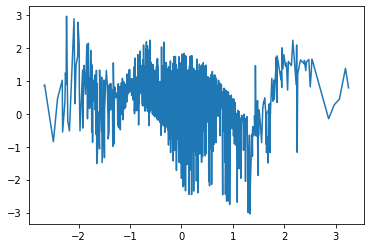

In [5]:
sns.lineplot(X[:,0], f_11)

<AxesSubplot:>

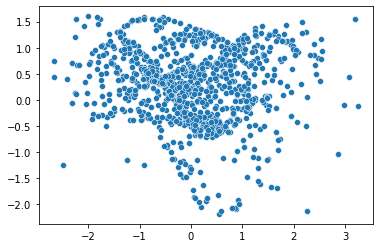

In [6]:
sns.scatterplot(X[:,0], Y[:,0])

<AxesSubplot:>

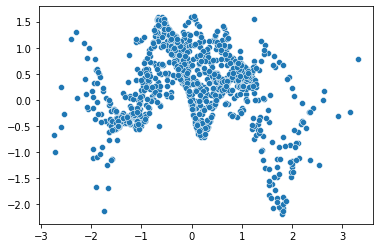

In [7]:
sns.scatterplot(X[:,1], Y[:,0])

In [8]:
sns.scatterplot(X[:,3], Y[:,0])

IndexError: index 3 is out of bounds for dimension 1 with size 2

<AxesSubplot:>

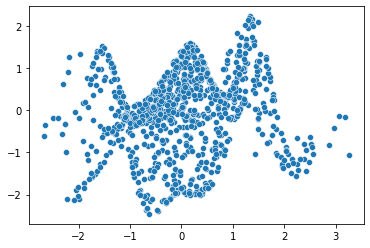

In [ ]:
sns.scatterplot(X[:,0], Y[:,1])

<AxesSubplot:>

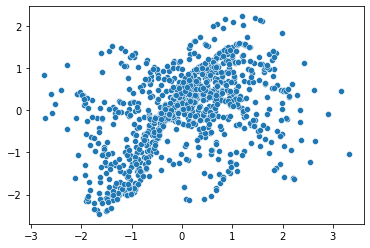

In [9]:
sns.scatterplot(X[:,1], Y[:,1])

In [10]:
sns.scatterplot(X[:,2], Y[:,1])

IndexError: index 2 is out of bounds for dimension 1 with size 2

In [11]:
sns.scatterplot(X[:,3], Y[:,1])

IndexError: index 3 is out of bounds for dimension 1 with size 2

<AxesSubplot:>

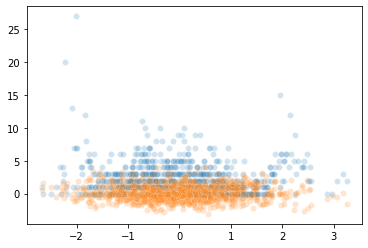

In [12]:
sns.scatterplot(X[:,0], y_1, alpha=.2)
# sns.scatterplot(X, y_2, alpha=.2)
sns.scatterplot(X[:,0], y_2, alpha=.2)

<AxesSubplot:>

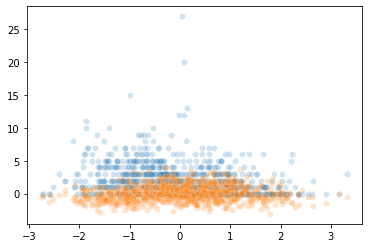

In [13]:
sns.scatterplot(X[:,1], y_1, alpha=.2)
# sns.scatterplot(X, y_2, alpha=.2)
sns.scatterplot(X[:,1], y_2, alpha=.2)

## Running model

Notes to make task_indices work:

- ```function_dist = self.pyro_guide(x)``` to include ```task_indices``` arg
- ```function_dist = self.pyro_model(x)``` to include ```task_indices``` arg
- check if ```function_dist.batch_shape``` and ```function_dist.event_shape``` for ```function_dist``` changes as a result adding in ```task_indices```
- setup train_x and task_indices as per [tutorial](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Hadamard_Multitask_GP_Regression.html)

In [14]:
inducing_pts1 = torch.linspace(0, 1, 100).expand(1, 2, 100).permute(0,2,1)[0,...]
inducing_pts2 = torch.linspace(0, 1, 100).expand(1, 2, 100).permute(0,2,1)[0,...]
active_dims = (0)
active_dims = torch.tensor(active_dims, dtype=torch.long)
inducing_pts1.shape
active_dims

tensor(0)

In [15]:
train_idx, test_idx = torch.utils.data.random_split(X, [.7, .3])
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
full_y = torch.stack([y_1, y_2], dim=-1)
train_y = full_y[train_idx,:]
test_y = full_y[test_idx,:]

# train_y = torch.stack([y_1, y_2], dim=-1)
# train_y = y_1
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

# model = MultitaskGPModel(num_tasks=6, num_latents=2, kernel_type="rbf")
gamma_mean = 2
gamma_std = 1
alpha = gamma_mean**2 / np.sqrt(gamma_std)
beta = gamma_mean / np.sqrt(gamma_std)
lengthscale_prior = gpytorch.priors.GammaPrior(alpha, beta)

kernel_list0 = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list0_1 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
               gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)]

kernel_list1 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list2 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]


kernel_list3 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list4 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.ProductKernel(
                                                  gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                                  gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)))]

kernel_list5 = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(lengthscale_prior=lengthscale_prior)), 
                                              gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)))]

kernel_list6 = [gpytorch.kernels.ProductKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior),
                                               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
                                                                               gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)))]

kernel_list7= [gpytorch.kernels.AdditiveKernel(
                    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[0]),
                    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[1])),
               gpytorch.kernels.AdditiveKernel(
                    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[0]),
                    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[1])),
               ]

kernel_list8= [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior) +
                    gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)
               ]

# kernel_list9= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, ard_num_dims=input_dim, batch_shape=torch.Size([2])), batch_shape=torch.Size([2])),
#                gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, ard_num_dims=input_dim, nu=5/2, batch_shape=torch.Size([2])), batch_shape=torch.Size([2]))]

batch_shape=torch.Size([1])

kernel_list10= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0], batch_shape=batch_shape), batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2, batch_shape=batch_shape), batch_shape=batch_shape)]

kernel_list11= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0])),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2))]

kernel_list12= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=(0))),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=(0))),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=(0), nu=5/2))]

# kernel_list13 does not work!
# look at "FAILS HERE" to see where it fails
kernel_list13= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ProductKernel(
                   gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),batch_shape=batch_shape),
                   gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),batch_shape=batch_shape))]

kernel_list14= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[1],batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[1],batch_shape=batch_shape),batch_shape=batch_shape)]

kernel_list15= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[1],batch_shape=batch_shape),batch_shape=batch_shape)]

kernel_list16= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ProductKernel(
                   gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape),
                   gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0],batch_shape=batch_shape),batch_shape=batch_shape))]

kernel_list17= [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, nu=5/2,batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.ProductKernel(
                   gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior,batch_shape=batch_shape),
                   gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior,batch_shape=batch_shape)))]

kernel_list18= [gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, batch_shape=batch_shape), batch_shape=batch_shape),
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(batch_shape=batch_shape),batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, nu=5/2, batch_shape=batch_shape), batch_shape=batch_shape),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, batch_shape=batch_shape), batch_shape=batch_shape)]

kernel_list19 = [gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, batch_shape=batch_shape),
                 gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, batch_shape=batch_shape),
                 gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, batch_shape=batch_shape),
                 gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, batch_shape=batch_shape),]

# kernel_list19[0].initialize_from_data(train_x[:,0].cpu(), train_y)
# kernel_list19[1].initialize_from_data(train_x[:,1].cpu(), train_y)

# kernel_list13= [gpytorch.kernels.AdditiveStructureKernel( 
#                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel               (lengthscale_prior=lengthscale_prior, active_dims=[0])) +
#                gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior, active_dims=[1], nu=5/2)), num_dims=2, active_dims=(1,2))]



likelihoods = ["Poisson", "HetGaussian"]
active_dims = [[0], [0], [1], [1]]
# active_dims = [[0], [0], [0], [0]]
# active_dims = [[0], [1]]

HetMOGP.ELBO_NORMALISER = train_y.size(0)
model = HetMOGP(train_x, num_lpf=3, likelihoods=likelihoods, kernels=kernel_list19, active_dims=active_dims, num_inducing=100, jitter_val = 1e-9)
# model = HetMOGP(train_x1, num_lpf=3, likelihoods=likelihoods, kernels=kernel_list17, active_dims=active_dims, num_inducing=100, jitter_val = 1e-9)

if torch.cuda.is_available():
    model = model.cuda()

In [16]:
# # kernel_list9= [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[0, 1], ard_num_dims=1),
# #                gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[0, 1])]

# kernel_list9= [gpytorch.kernels.AdditiveKernel(gpytorch.kernels.RBFKernel(active_dims=[0]),
#                gpytorch.kernels.RBFKernel(active_dims=[1]))]

# test = LMCSeparableKernel(kernel_list9, batch_shape=torch.Size([len(kernel_list9)]))

# for n, p in test.named_parameters():
#     print(n, p)

In [17]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1200 # for actual training
# num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
# elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    # model(train_x, task_indices="YOLO")
    # model(train_x, task_indices=task_indices)
    loss = svi.step(x=train_x, y=train_y)
    # loss = svi.step(x=train_x1, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1200 [00:00<?, ?it/s]

<AxesSubplot:>

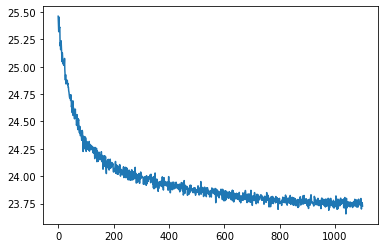

In [18]:
loss_start = 100
sns.lineplot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])

In [19]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [20]:
n_posterior_samples = 1000

model.eval()

with torch.no_grad():
    output = model(test_x)
    output_train = model(train_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([n_posterior_samples]))
samples_train = output_train(torch.Size([n_posterior_samples]))

lower, mean, upper = percentiles_from_samples(samples.cpu())
lower_train, mean_train, upper_train = percentiles_from_samples(samples_train.cpu())
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Poisson(mean[:,0].detach().exp())(), 
     dist.Normal(mean[:,1].detach(), mean[:,2].detach().exp())()],
    dim=-1
)

y_sim_train = torch.stack(
    [dist.Poisson(mean_train[:,0].detach().exp())(), 
     dist.Normal(mean_train[:,1].detach(), mean_train[:,2].detach().exp())()],
    dim=-1
)

In [21]:
# longer length scale
loss_array[-1]

23.728132033348082

In [22]:
# longer length scale
nlpd = torch.stack([-dist.Poisson(mean[:,0].detach().exp().cpu()).log_prob(test_y[:,0].cpu()),
                   -dist.Normal(mean[:,1].detach().cpu(), mean[:,2].detach().exp().cpu()).log_prob(test_y[:,1].cpu())])

nlpd_train = torch.stack([-dist.Poisson(mean_train[:,0].detach().exp().cpu()).log_prob(train_y[:,0].cpu()),
                          -dist.Normal(mean_train[:,1].detach().cpu(), mean_train[:,2].detach().exp().cpu()).log_prob(train_y[:,1].cpu())])

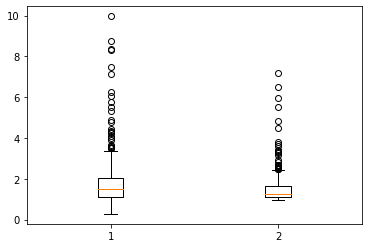

In [23]:
# longer length scale
fig, ax = plt.subplots()
ax.boxplot(nlpd);

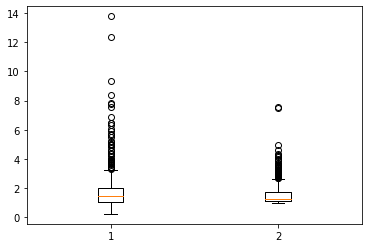

In [24]:
# longer length scale
fig, ax = plt.subplots()
ax.boxplot(nlpd_train);

In [25]:
# longer length scale
torch.stack([-dist.Poisson(mean[:,0].detach().exp().cpu()).log_prob(test_y[:,0].cpu()).sum(),
                   -dist.Normal(mean[:,1].detach().cpu(), mean[:,2].detach().exp().cpu()).log_prob(test_y[:,1].cpu()).sum()]) / 300

tensor([1.8789, 1.5513])

In [26]:
# longer length scale
torch.stack([-dist.Poisson(mean_train[:,0].detach().exp().cpu()).log_prob(train_y[:,0].cpu()).sum(),
                   -dist.Normal(mean_train[:,1].detach().cpu(), mean_train[:,2].detach().exp().cpu()).log_prob(train_y[:,1].cpu()).sum()]) / 700

tensor([1.7610, 1.5549])

In [27]:
# longer length scale
nlpd = torch.stack([-dist.Poisson(mean[:,0].detach().exp().cpu()).log_prob(test_y[:,0].cpu()),
                   -dist.Normal(mean[:,1].detach().cpu(), mean[:,2].detach().exp().cpu()).log_prob(test_y[:,1].cpu())])

nlpd_train = torch.stack([-dist.Poisson(mean_train[:,0].detach().exp().cpu()).log_prob(train_y[:,0].cpu()),
                          -dist.Normal(mean_train[:,1].detach().cpu(), mean_train[:,2].detach().exp().cpu()).log_prob(train_y[:,1].cpu())])

In [28]:
nlpd[1,:].mean(), nlpd[1,:].std()

(tensor(1.5513), tensor(0.8128))

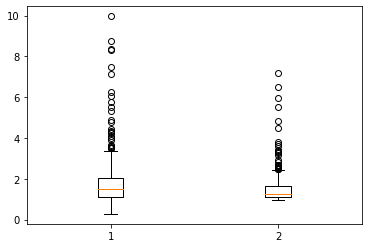

In [29]:
# longer length scale
fig, ax = plt.subplots()
ax.boxplot(nlpd);

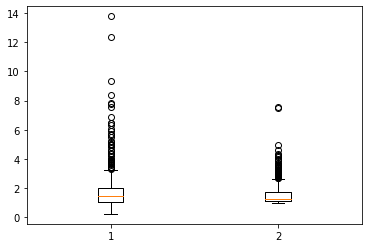

In [30]:
# longer length scale
fig, ax = plt.subplots()
ax.boxplot(nlpd_train);

In [31]:
# longer length scale
torch.stack([-dist.Poisson(mean[:,0].detach().exp().cpu()).log_prob(test_y[:,0].cpu()).sum(),
                   -dist.Normal(mean[:,1].detach().cpu(), mean[:,2].detach().exp().cpu()).log_prob(test_y[:,1].cpu()).sum()]) / 300

tensor([1.8789, 1.5513])

In [32]:
# longer length scale
torch.stack([-dist.Poisson(mean_train[:,0].detach().exp().cpu()).log_prob(train_y[:,0].cpu()).sum(),
                   -dist.Normal(mean_train[:,1].detach().cpu(), mean_train[:,2].detach().exp().cpu()).log_prob(train_y[:,1].cpu()).sum()]) / 700

tensor([1.7610, 1.5549])

ValueError: x and y must be the same size

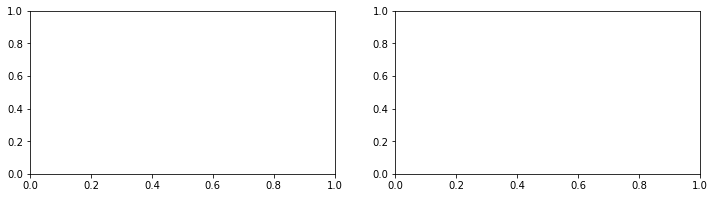

In [33]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
func.scatter(test_x, mean[:,0].detach().cpu().numpy(), label='GP prediction')
# func.fill_between(
#     test_x[:,0], lower[:,0].squeeze().detach().cpu().numpy(),
#     upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

# func.scatter(test_x, f_11, label='True latent function')
# func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

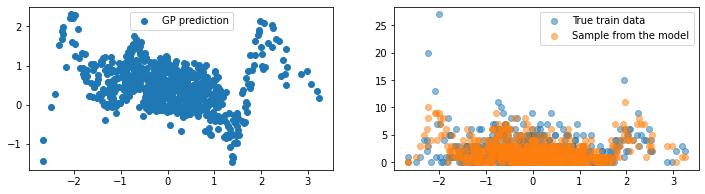

In [34]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
func.scatter(train_x[:,0], mean_train[:,0].detach().cpu().numpy(), label='GP prediction')
# func.fill_between(
#     test_x[:,0], lower[:,0].squeeze().detach().cpu().numpy(),
#     upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

# func.scatter(test_x[:,0], f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,0], train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x[:,0], y_sim_train[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

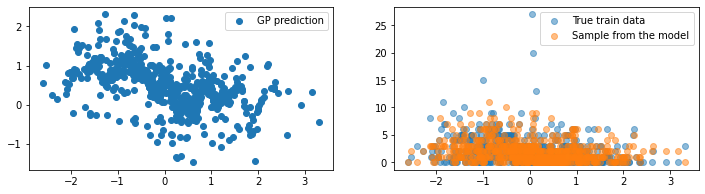

In [35]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
func.scatter(train_x[:,1], mean_train[:,0].detach().cpu().numpy(), label='GP prediction')
# func.fill_between(
#     test_x[:,1], lower[:,0].squeeze().detach().cpu().numpy(),
#     upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

# func.scatter(test_x[:,1], f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,1], train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x[:,1], y_sim_train[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

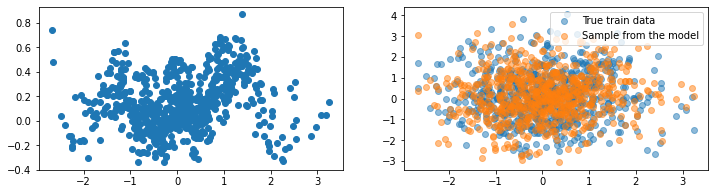

In [36]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))

# for i,j in enumerate(range(0,1)):
func.scatter(train_x[:,0], mean_train[:,1].detach().cpu().numpy(), label='GP prediction')
# func[i].fill_between(
#     test_x[:,0], lower[:,j].squeeze().detach().cpu().numpy(),
#     upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

# func.scatter(train_x[:,0], f_21, label='True latent function')
# func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,0], train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x[:,0], y_sim_train[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

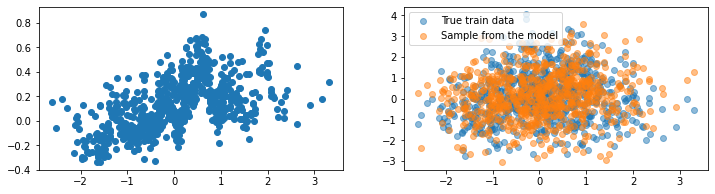

In [37]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))

# for i,j in enumerate(range(0,1)):
func.scatter(train_x[:,1], mean_train[:,1].detach().cpu().numpy(), label='GP prediction')
# func[i].fill_between(
#     test_x[:,0], lower[:,j].squeeze().detach().cpu().numpy(),
#     upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

# func.scatter(test_x[:,1], f_21, label='True latent function')
# func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,1], train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x[:,1], y_sim_train[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

## Testing the code

In [38]:
model.eval()

with torch.no_grad():
    latent_dist_draw = model.variational_strategy.latent_dist.sample(torch.Size([1000]))
    latent_dist_draw = latent_dist_draw.cpu()
    
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()
    test = model.variational_strategy.latent_dist

lower_latent, mean_latent, upper_latent = percentiles_from_samples(latent_dist_draw)


In [39]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [40]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

<AxesSubplot:>

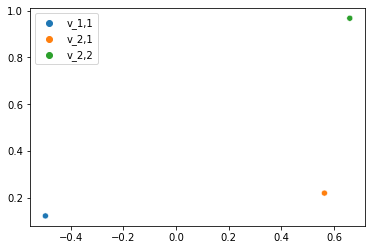

In [41]:
labels = ["v_1,1", "v_2,1", "v_2,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

<AxesSubplot:>

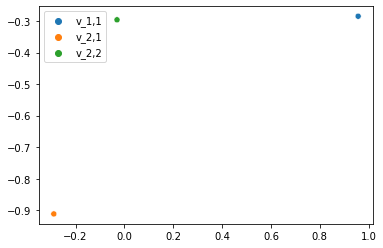

In [42]:
labels = ["v_1,1", "v_2,1", "v_2,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=False)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

In [50]:
latent_dist_draw.shape

torch.Size([1000, 4, 700])

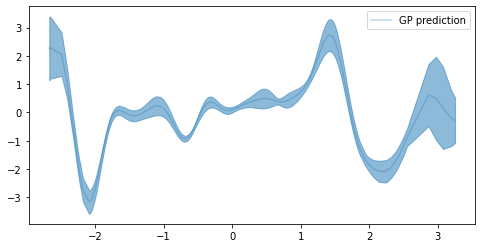

In [68]:
# visualize the result
fig, func = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
indices = np.argsort(train_x[:,0])
line, = func.plot(train_x[indices,0], mean[0,indices], label='GP prediction', alpha=0.3)
func.fill_between(
    train_x[indices,0], lower[0,indices],
    upper[0,indices], alpha=0.5, color=line.get_color()
)
# test_x1 = test_x1.cpu()
# indices = np.argsort(test_x1)
# line, = func.plot(test_x1[indices], mean[0,indices], label='GP prediction', alpha=0.3)
# func.fill_between(
#     test_x1[indices], lower[0,indices],
#     upper[0,indices], alpha=0.5, color=line.get_color()
# )
# func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
func.legend()


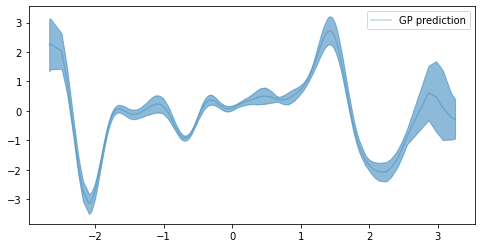

In [43]:
# visualize the result
fig, func = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
indices = np.argsort(train_x[:,0])
line, = func.plot(train_x[indices,0], mean_latent[0,indices], label='GP prediction', alpha=0.3)
func.fill_between(
    train_x[indices,0], lower_latent[0,indices],
    upper_latent[0,indices], alpha=0.5, color=line.get_color()
)
# test_x1 = test_x1.cpu()
# indices = np.argsort(test_x1)
# line, = func.plot(test_x1[indices], mean[0,indices], label='GP prediction', alpha=0.3)
# func.fill_between(
#     test_x1[indices], lower[0,indices],
#     upper[0,indices], alpha=0.5, color=line.get_color()
# )
# func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
func.legend()


In [246]:
with torch.no_grad():

    inducing_pts_mean = model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean.cpu()
    inducing_pts = model.variational_strategy.base_variational_strategy.inducing_points.cpu()

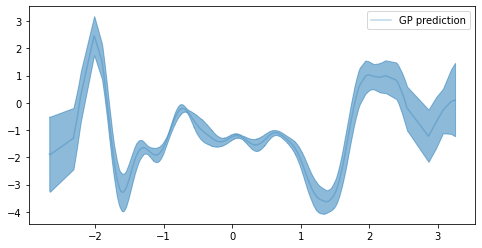

In [247]:
# visualize the result
fig, func = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
indices = np.argsort(train_x[:,0])
line, = func.plot(train_x[indices,0], mean_latent[0,indices], label='GP prediction', alpha=0.3)
func.fill_between(
    train_x[indices,0], lower_latent[0,indices],
    upper_latent[0,indices], alpha=0.5, color=line.get_color()
)
# func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
func.legend()


In [248]:
f_pred_mean = (mean_latent.T @ lmc_coefficients)
f_pred_lower = (lower_latent.T @ lmc_coefficients)
f_pred_upper = (upper_latent.T @ lmc_coefficients)

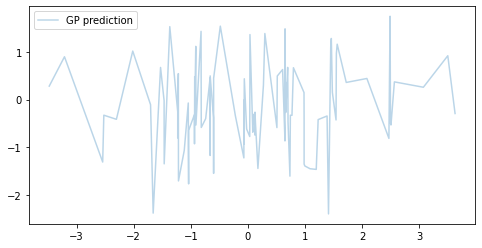

In [249]:
# visualize the result
fig, func = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
input_dim_inducing = 0
output_dim = 0
indices = np.argsort(model.variational_strategy.base_variational_strategy.inducing_points[0,:,input_dim_inducing].detach().cpu())
inducing_points_ordered = model.variational_strategy.base_variational_strategy.inducing_points[0,indices,input_dim_inducing].detach().cpu()
mean_inducing_values = model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean[output_dim,indices].detach().cpu()
line, = func.plot(inducing_points_ordered, mean_inducing_values, label='GP prediction', alpha=0.3)
# func.fill_between(
#     test_x[indices,0], lower[0,indices],
#     upper[0,indices], alpha=0.5, color=line.get_color()
# )
# func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
func.legend()


In [250]:
latent_dist_draw.size(-2)

4

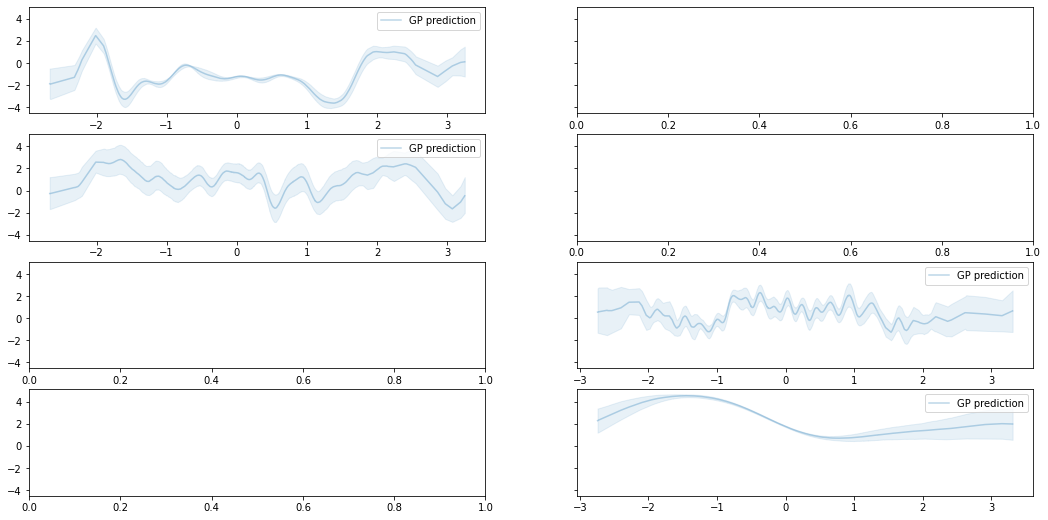

In [251]:
# visualize the result
fig, func = plt.subplots(latent_dist_draw.size(-2), input_dim, figsize=(18, 9), sharey=True)

scale_adj = torch.tensor([-.8, .8]) # scale the true GP
for i in range(latent_dist_draw.size(-2)):
    for j in range(input_dim):
        if active_dims[i] == [j]:
            indices = np.argsort(train_x[:,j])
            line, = func[i,j].plot(train_x[indices,j], mean_latent[i,indices], label='GP prediction', alpha=0.3)
            func[i, j].fill_between(
                train_x[indices,j], lower_latent[i,indices],
                upper_latent[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
            func[i,j].legend()


IndexError: index 152 is out of bounds for dimension 0 with size 3

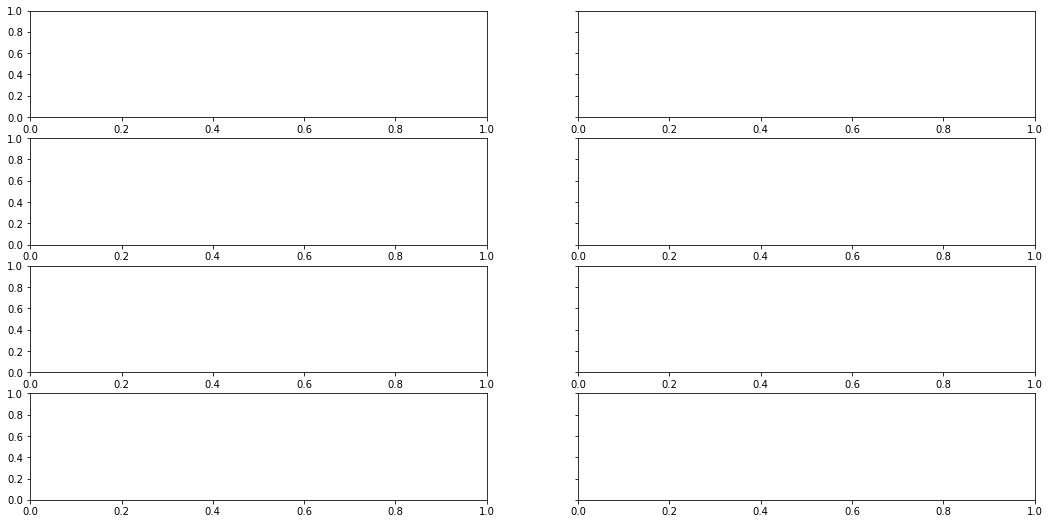

In [252]:
# visualize the result
fig, func = plt.subplots(latent_dist_draw.size(-2), input_dim, figsize=(18, 9), sharey=True)

scale_adj = torch.tensor([-.8, .8]) # scale the true GP
# active_dims_ = [[0], [0], [1], [1], [1]]
for i in range(latent_dist_draw.size(-2)):
    for j in range(input_dim):
        # if active_dims_[i] == [j]:
        indices = np.argsort(test_x[:,j])
        line, = func[i,j].plot(test_x[indices,j], mean[i,indices], label='GP prediction', alpha=0.3)
        func[i, j].fill_between(
            test_x[indices,j], lower[i,indices],
            upper[i,indices], alpha=0.1, color=line.get_color()
        )
        # func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
        func[i,j].legend()


In [255]:
def compute_f_pd(input, d_lpf, lpf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input])
    indices = np.argsort(test_x[:,input])
    f_pd = (lpf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,d_lpf]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

IndexError: index 152 is out of bounds for dimension 0 with size 3

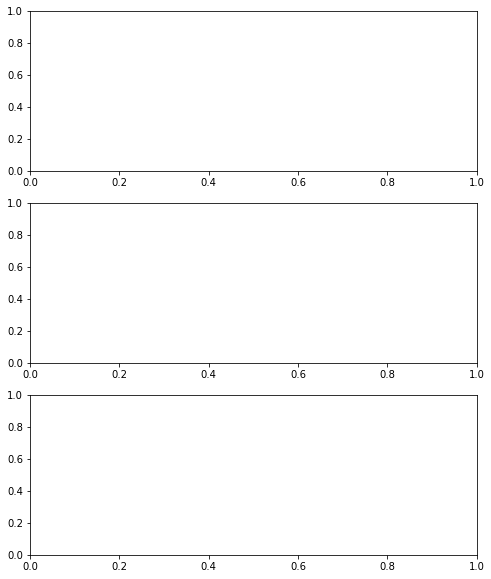

In [256]:
# visualize the result
fig, (*func, samp) = plt.subplots(input_dim+1, 1, figsize=(8, 10))

for j in range(input_dim):
    indices, f11_mean = compute_f_pd(j, 0, mean, lmc_coefficients, active_dims)
    _, f11_lower = compute_f_pd(j, 0, lower, lmc_coefficients, active_dims)
    _, f11_upper = compute_f_pd(j, 0, upper, lmc_coefficients, active_dims)
    line, = func[j].plot(test_x[indices,j], f11_mean, label=f'LPF{1} for input {j+1}', alpha=0.3)
    func[j].fill_between(
        test_x[indices,j], f11_lower,
        f11_upper, alpha=0.1, color=line.get_color()
    )
    func[j].legend()

func[0].sharey(func[1])

samp.scatter(train_x[:,0], train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x[:,0], y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

IndexError: index 152 is out of bounds for dimension 0 with size 3

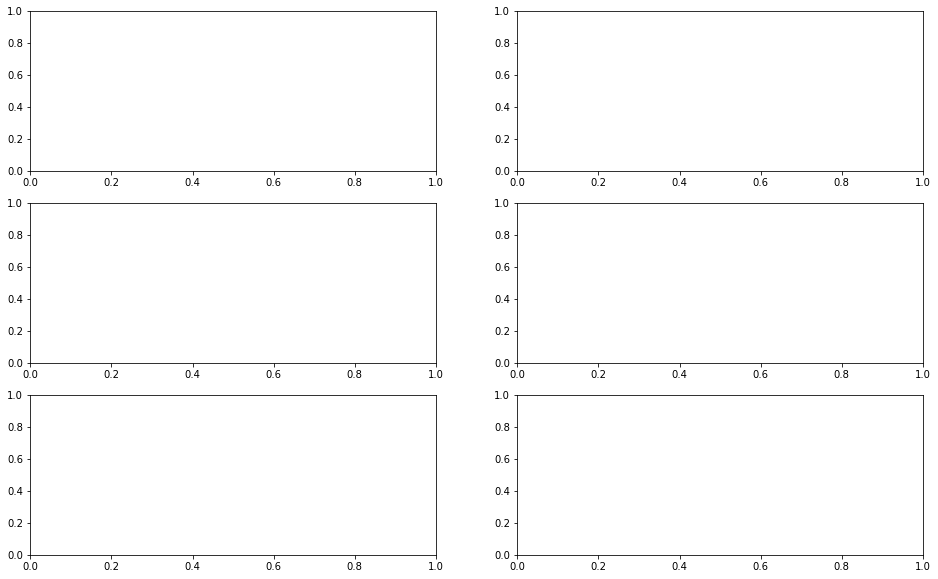

In [257]:
# visualize the result
latent_dim = 2
fig, (*func, samp) = plt.subplots(input_dim+1, latent_dim, figsize=(16, 10))

for i in range (latent_dim):
    for j in range(input_dim):
        indices, f11_mean = compute_f_pd(j, i+1, mean, lmc_coefficients, active_dims)
        _, f11_lower = compute_f_pd(j, i+1, lower, lmc_coefficients, active_dims)
        _, f11_upper = compute_f_pd(j, i+1, upper, lmc_coefficients, active_dims)
        line, = func[i][j].plot(test_x[indices,j], f11_mean, label=f'LPF{i+2} for input {j+1}', alpha=0.3)
        func[i][j].fill_between(
            test_x[indices,j], f11_lower,
            f11_upper, alpha=0.1, color=line.get_color()
        )
        func[i][j].legend()

# func[0].sharey(func[1])

samp[0].scatter(train_x[:,0], train_y[:,1], alpha = 0.5, label='True train data')
samp[0].scatter(train_x[:,0], y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp[0].legend()
samp[1].scatter(train_x[:,1], train_y[:,1], alpha = 0.5, label='True train data')
samp[1].scatter(train_x[:,1], y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp[1].legend()

In [263]:
lmc_coefficients

tensor([[ 1.0218, -0.1193,  0.0729],
        [-0.0758, -1.2401, -0.5110],
        [ 1.0422, -0.6420, -0.1379],
        [-1.0362, -0.7665, -0.0862]])

In [57]:
for n, p in model.named_parameters():
    print(n, p)

variational_strategy.lmc_coefficients Parameter containing:
tensor([[ 0.0463,  0.0523,  0.0326],
        [ 0.2401, -0.1652, -0.0053],
        [ 0.5996,  0.2976,  0.1178],
        [ 1.0499, -1.0306, -0.4594]], device='cuda:0', requires_grad=True)
variational_strategy.base_variational_strategy.inducing_points Parameter containing:
tensor([[[ 0.1958, -1.7162],
         [-0.6549,  0.4623],
         [ 1.4008,  0.2793],
         [-0.0209,  0.8597],
         [-1.5824, -0.6438],
         [ 0.8290, -0.2093],
         [-1.4673, -0.4951],
         [-1.4410, -0.8214],
         [ 0.1393, -1.1672],
         [ 0.8350, -1.3640],
         [-1.3905,  0.3073],
         [-1.3018, -1.5034],
         [-1.1388, -0.1306],
         [ 0.1891, -0.1493],
         [ 0.7311,  0.6494],
         [-0.1435,  0.0659],
         [-0.1350, -0.1612],
         [-0.0051,  1.4864],
         [ 0.0883,  0.2400],
         [ 0.1864,  0.3040],
         [ 0.2915,  0.0282],
         [-0.2315,  0.8497],
         [-0.2220, -1.0055],
  

tensor([[ 0.0076, -0.0210, -0.0545,  ..., -0.1724, -0.1513, -0.1787],
        [ 0.6086,  0.6789,  0.7237,  ...,  0.8725,  0.8351,  0.8913],
        [ 0.8009,  0.1806,  0.4791,  ...,  1.1470,  1.2472,  1.0297],
        [-0.2350, -0.3196, -0.3334,  ...,  0.0869, -0.0303,  0.2835]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [397]:
# 1 x n_inducing x p_dimension
# 100 inducing points for each input dimension
model.variational_strategy.base_variational_strategy.inducing_points.shape

torch.Size([1, 100, 2])

In [398]:
# mean vector of u(inducing_points) 
model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean.shape

torch.Size([4, 100])

In [399]:
# covariance of u(inducing_points). diagonal covariance between and across outcomes
model.variational_strategy.base_variational_strategy._variational_distribution._variational_stddev.shape

torch.Size([4, 100])

IndexError: index 3 is out of bounds for dimension 1 with size 3

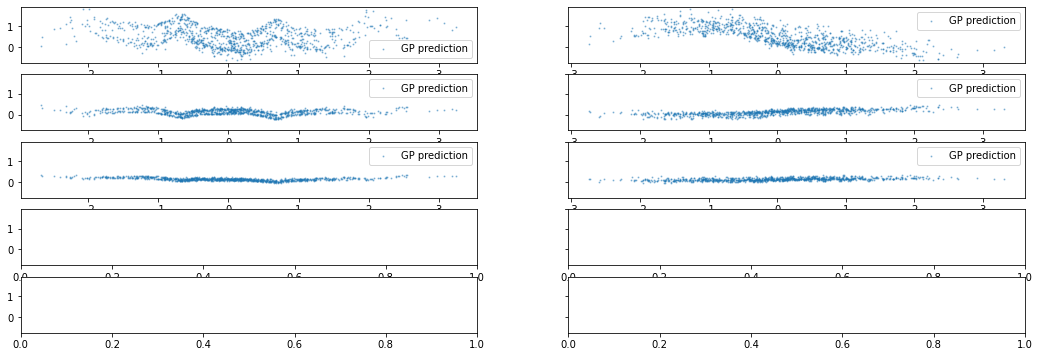

In [148]:
# visualize the result
fig, func = plt.subplots(latent_dist_draw.size(-2), input_dim, figsize=(18, 6), sharey=True)

scale_adj = torch.tensor([-.8, .8]) # scale the true GP

for i in range(latent_dist_draw.size(-2)):
    for j in range(input_dim):
        func[i,j].scatter(test_x[:,j], f_pred[:,i], label='GP prediction', alpha=0.4, s=1)
        # func[i].fill_between(
        #     test_x[:,0], lower[i,:],
        #     upper[i,:], alpha=0.5, color=line.get_color()
        # )
        # func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
        func[i,j].legend()


In [783]:
lmc_coefficients

tensor([[ 0.3042, -0.7968, -0.1663],
        [-0.1591, -0.0449,  0.0163]])

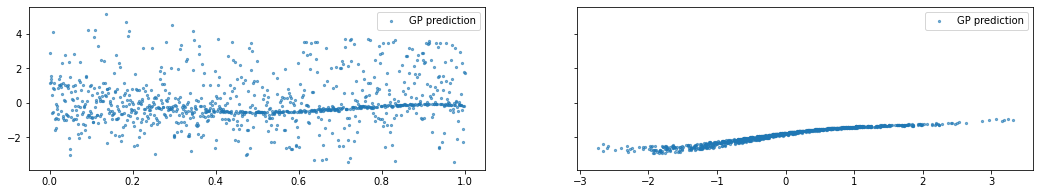

In [492]:
# visualize the result
fig, func = plt.subplots(1, latent_dist_draw.size(-2), figsize=(18, 3), sharey=True)

scale_adj = torch.tensor([-.8, .8]) # scale the true GP

for i in range(latent_dist_draw.size(-2)):
    func[i].scatter(test_x[:,i], mean[i,:], label='GP prediction', alpha=0.6, s=5)
    # func[i].fill_between(
    #     test_x[:,0], lower[i,:],
    #     upper[i,:], alpha=0.5, color=line.get_color()
    # )
    # func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
    func[i].legend()


In [511]:
lmc_coefficients

tensor([[ 0.1106, -1.6577, -0.8630],
        [ 0.2545,  2.3376,  0.3053]])

In [586]:
x1 = torch.linspace(0, 1, 5)
x2 = torch.linspace(0, 1, 5)

x1_grid, x2_grid = torch.meshgrid([x1, x2])
X_grid = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))

In [587]:
X_grid[:,0].shape

torch.Size([25])

In [601]:
model.

MultivariateNormal(loc: torch.Size([2, 200]))

In [593]:
with torch.no_grad():
    test = model(X_grid.cuda())

In [599]:
test.

<bound method Distribution.score_parts of MultitaskMultivariateNormal(loc: torch.Size([150]))>

In [588]:
test(X_grid)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'torch.Size'

In [548]:
with torch.no_grad():
    test = model.variational_strategy.latent_dist

In [569]:
model.variational_strategy.latent_dist.sample(torch.Size([1000])).shape

torch.Size([1000, 2, 10000])

In [553]:
sns.lineplot(torch.linspace(0, 1, N), model.variational_strategy.latent_dist()[0]

ValueError: All arrays must be of the same length

In [549]:
test

MultivariateNormal(loc: torch.Size([2, 10000]))

In [530]:
model.variational_strategy

LMCVariationalStrategy(
  (base_variational_strategy): VariationalStrategy(
    (_variational_distribution): MeanFieldVariationalDistribution()
  )
)

In [534]:
test().shape

torch.Size([2, 10000])

In [527]:
test.sample().shape

torch.Size([10000, 6])

In [524]:
sns.lineplot(X_grid[:,0], test.cpu())


AttributeError: 'MultitaskMultivariateNormal' object has no attribute 'cpu'

<AxesSubplot:>

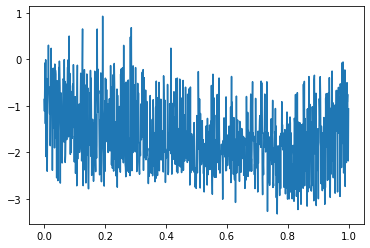

In [648]:
sns.lineplot(torch.linspace(0,1,N), latent_dist_draw[0,0,:])

In [150]:
mean.shape

torch.Size([1000, 6])

ValueError: x and y must be the same size

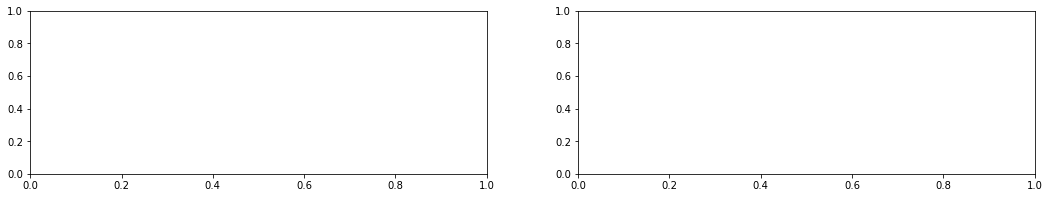

In [465]:
func.plot

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [433]:
lmc_coefficients.abs()

tensor([[0.2976, 0.6633, 0.2556, 0.1816, 0.1623, 0.0214],
        [1.4409, 0.1154, 0.4777, 2.1622, 1.5481, 0.2113]])

In [455]:
(lmc_coefficients / lmc_coefficients.norm(dim=0)).abs()

tensor([[0.2023, 0.9852, 0.4718, 0.0837, 0.1043, 0.1005],
        [0.9793, 0.1714, 0.8817, 0.9965, 0.9945, 0.9949]])

In [234]:
torch.matmul(torch.matmul(model.covar_module.kernel_modules[1].kernels[1].forward(torch.linspace(0,1,100).expand(2,100).T.cuda(), train_x.cuda()).detach(),
             torch.linalg.inv(model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), train_x.cuda()).detach())),
             train_y.cuda())

tensor([[ 1.9621e+02, -1.0749e+02, -1.0018e+01,  1.6380e+01],
        [-2.6241e+02, -9.1127e+01, -7.1448e+01,  6.1492e+01],
        [-8.5248e+02,  7.0574e+01,  1.2827e+02, -2.6106e+01],
        [ 5.6284e+02, -1.1733e+02, -2.1688e+02,  9.3123e+01],
        [-1.4093e+02, -3.0901e+01, -2.1194e+02,  2.7963e+01],
        [-5.1517e+02, -5.7495e+00, -7.1203e+01,  1.5318e+00],
        [-1.0719e+03, -4.9065e+00, -2.5408e+02, -3.9783e+01],
        [ 4.5269e+01, -1.6458e+02, -1.4053e+02,  1.3965e+01],
        [ 2.9809e+01, -2.7801e+01, -1.6584e+01,  2.1681e+01],
        [-6.2085e+02,  4.2958e+01, -1.6339e+02, -4.3333e+01],
        [-9.4787e+02,  1.2127e+02, -1.5985e+01, -4.8742e+01],
        [ 2.4112e+02, -8.5392e+00,  1.9639e+02, -5.9374e+01],
        [-4.5770e+02,  1.9142e+02,  3.6580e+02, -6.6735e+01],
        [-1.5542e+02,  3.0391e+01, -1.1079e+01, -1.5246e+01],
        [-2.1070e+03,  2.0609e+02,  3.7545e+02, -1.1480e+02],
        [ 3.1772e+02, -7.4701e+01, -1.3880e+02,  7.8373e+00],
        

In [215]:
torch.linalg.inv(model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), train_x.cuda()).detach())

tensor([[ -20646.3496,   28245.0352,   -7681.4888,  ...,   21476.1387,
         -142824.0156,  127749.0547],
        [ -37323.1016,  194033.0938,   -7293.6289,  ...,   92760.3984,
           20489.0742,  382911.3750],
        [ -62863.7227,   43918.6094,  -53302.2695,  ...,   19698.1191,
           66279.1562,   29607.1211],
        ...,
        [   5316.9790,   56970.0391,   59390.2539,  ...,   61759.0039,
          -16879.7695,   58444.3516],
        [ -43380.5664,  119241.5781,  -21799.4648,  ...,   61595.2930,
         -172870.6250,  258117.0156],
        [  31855.6680,   31031.0957,  -47980.4336,  ...,   33687.1719,
           40162.4688,   74709.0000]], device='cuda:0')

In [210]:
model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), torch.linspace(0,1,100).expand(2,100).T.cuda()).detach().shape

torch.Size([1000, 100])

In [203]:
model.covar_module.kernel_modules[1].kernels[1].forward(torch.linspace(0,1,100).expand(2,100).T.cuda(), train_x.cuda()).detach().shape

torch.Size([100, 1000])

In [169]:
model.covar_module.kernel_modules[1].kernels[1].lengthscale

tensor([[0.9802, 0.2859]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [113]:
super()

TypeError: super() argument 1 must be type, not LMCVariationalStrategy

In [103]:
type(model.variational_strategy)

__main__.LMCVariationalStrategy

In [111]:
model.variational_strategy.__call__?

Signature:
model.variational_strategy.__call__(
    x,
    task_indices=None,
    prior=False,
    **kwargs,
)
Docstring:
Computes the variational (or prior) distribution
:math:`q( \mathbf f \mid \mathbf X)` (or :math:`p( \mathbf f \mid \mathbf X)`).
There are two modes:

1.  Compute **all tasks** for all inputs.
    If this is the case, the task_indices attribute should be None.
    The return type will be a (... x N x num_tasks)
    :class:`~gpytorch.distributions.MultitaskMultivariateNormal`.
2.  Compute **one task** per inputs.
    If this is the case, the (... x N) task_indices tensor should contain
    the indices of each input's assigned task.
    The return type will be a (... x N)
    :class:`~gpytorch.distributions.MultivariateNormal`.

:param x: Input locations to evaluate variational strategy
:type x: torch.Tensor (... x N x D)
:param task_indices: (Default: None) Task index associated with each input.
    If this **is not** provided, then the returned distribution evaluate

In [108]:
super(type(model.variational_strategy))

<super: __main__.LMCVariationalStrategy, None>

In [98]:
model.variational_strategy.__call__(train_x.cuda(), **{"inducing_values":model.variational_strategy.variational_distribution.mean})

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [90]:
model.__call__(train_x.cuda(), inducing_values=model.variational_strategy.variational_distribution.mean)

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [84]:
model.variational_strategy(train_x.cuda(), inducing_values=model.variational_strategy.variational_distribution.mean)

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [674]:
# additive(product(kernels))
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-1.0279, -1.2727]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.1001]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.2494,  7.7436]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[2.0656, 9.6590]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.1.raw_period_length Parameter containing:
tensor([[2.3995, 9.3742]], device='cuda:0', requires_grad=True)


In [624]:
# active_dims = [2] for kernel_modules.1.kernels.0.raw_lengthscale
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-0.9088, -0.7308]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[1.2634]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[-1.2638,  0.9277]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_period_length Parameter containing:
tensor([[0.1018, 1.2464]], device='cuda:0', requires_grad=True)


In [601]:
# ard_num_dims = 2
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-0.8014,  0.8889]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[3.9538, 4.0094]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[-1.9631,  0.1536]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_period_length Parameter containing:
tensor([[ 0.1112, -0.4233]], device='cuda:0', requires_grad=True)


In [171]:
# ard_num_dims = 1

for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_outputscale Parameter containing:
tensor(-1.2919, device='cuda:0', requires_grad=True)
kernel_modules.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.0921]], device='cuda:0', requires_grad=True)
kernel_modules.1.raw_outputscale Parameter containing:
tensor(-0.9076, device='cuda:0', requires_grad=True)
kernel_modules.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[-2.8909]], device='cuda:0', requires_grad=True)
kernel_modules.1.base_kernel.raw_period_length Parameter containing:
tensor([[2.7322]], device='cuda:0', requires_grad=True)


In [305]:
model.covar_module.base_kernels[0].base_kernel.lengthscale

tensor([[0.5366]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [306]:
model.covar_module.base_kernels[1].base_kernel.lengthscale

tensor([[0.4790]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [307]:
model.covar_module.base_kernels[1].base_kernel.period_length

tensor([[0.7506]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [308]:
for n, p in model.named_parameters():
    print("name:", n)
    print("parameter:", p)
    print("\n")

name: variational_strategy.lmc_coefficients
parameter: Parameter containing:
tensor([[ 1.0907, -0.5130,  0.9489, -0.0432, -0.0740, -0.1966],
        [-0.0134,  0.1573, -0.0139,  0.8519,  0.8607,  0.0806]],
       device='cuda:0', requires_grad=True)


name: variational_strategy.base_variational_strategy.inducing_points
parameter: Parameter containing:
tensor([[-0.0752],
        [-0.0793],
        [ 0.0260],
        [ 0.0257],
        [ 0.0257],
        [ 0.0261],
        [-0.0772],
        [-0.0773],
        [-0.0774],
        [-0.0775],
        [ 0.0262],
        [ 0.0279],
        [ 0.0263],
        [ 0.1749],
        [-0.0775],
        [ 0.0269],
        [ 0.0284],
        [ 0.0262],
        [ 0.0264],
        [ 0.0264],
        [ 0.0275],
        [ 0.0265],
        [ 0.0273],
        [ 0.0270],
        [ 0.0271],
        [ 0.0284],
        [ 0.0305],
        [ 0.0274],
        [ 0.0279],
        [ 0.0280],
        [ 0.2491],
        [ 0.0273],
        [ 0.0272],
        [ 0.1749],


In [402]:
with torch.no_grad():
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()

# A_hat = torch.divide(A_hat.T, torch.norm(A_hat, dim=-1)).T

In [409]:
(A * scale_adj).T

tensor([[ 0.8000, -6.7200, -2.9120,  0.1600,  0.1600,  0.8000],
        [-0.2600, -0.0250,  0.1250,  0.5500,  0.5500,  0.0500]])

In [421]:
lmc_coefficients

tensor([[-0.2976, -0.6633, -0.2556,  0.1816,  0.1623,  0.0214],
        [-1.4409, -0.1154,  0.4777,  2.1622,  1.5481,  0.2113]])

In [418]:
A.T

tensor([[-0.2500,  2.1000,  0.9100, -0.0500, -0.0500, -0.2500],
        [-0.5200, -0.0500,  0.2500,  1.1000,  1.1000,  0.1000]])

In [420]:
(lmc_coefficients.T * scale_adj).T

tensor([[ 0.9523,  2.1226,  0.8179, -0.5811, -0.5194, -0.0683],
        [-0.7204, -0.0577,  0.2388,  1.0811,  0.7741,  0.1057]])

In [359]:
latent_dist.lazy_covariance_matrix

In [367]:
lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))

In [380]:
latent_dist.lazy_covariance_matrix.cpu()

In [382]:
covar = KroneckerProductLinearOperator(latent_dist.lazy_covariance_matrix.cpu(), lmc_factor).sum(-1)

In [450]:
covar.shape

torch.Size([2, 6000])

In [456]:
(covar.T @ covar).shape

torch.Size([6000, 6000])

In [390]:
latent_dist.lazy_covariance_matrix.shape

torch.Size([2, 1000, 1000])

In [387]:
covar[0].shape

torch.Size([6000])

In [215]:
x_multi = torch.randn([500, 3])
init_covar_x = torch.randn([1, 500, 500])
covar_x = torch.randn([2, 1, 500, 500])
x1 = torch.randn([500,1])
x2 = torch.randn([1,500,1])

In [229]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2]))

In [230]:
kernel._

OrderedDict([('raw_outputscale',
              Parameter containing:
              tensor(0., requires_grad=True))])

In [217]:
test = kernel(x_multi).evaluate_kernel()
test.shape

torch.Size([500, 500])

In [287]:
kernel = LMCKernel(
    [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3, active_dims=[0, 7000])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims=[0, 2]))],
    batch_shape=2
)

In [288]:
test = kernel(x).evaluate_kernel()
test.shape

params: {'last_dim_is_batch': False}
init_x_shape: torch.Size([500, 1])
x_shape: torch.Size([1, 500, 1])
init_covar_x.shape: torch.Size([1, 500, 500])
kernel: ScaleKernel(
  (base_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)
covar_x.shape: torch.Size([2, 500, 500])


torch.Size([2, 500, 500])

In [244]:
kernel_list = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())]

kernel = torch.nn.ModuleList(
    kernel_list
)

In [246]:
kernel[0](x_multi).evaluate_kernel().shape

torch.Size([500, 500])

In [398]:
num_latents=2
num_tasks=6
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
                                batch_shape=torch.Size([num_latents])) + \
                        gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
                            batch_shape=torch.Size([num_latents]))

# torch.Size([2, 1000, 1000]) # CORRECT!                        
# kernel(train_x).shape

torch.Size([2, 1000, 1000])

In [396]:
kernel = gpytorch.kernels.LCMKernel(
                            [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()],
                            num_tasks=num_tasks
                        )

# torch.Size([6000, 6000]) # WRONG!
# kernel(train_x).shape

In [642]:
kernel_list = torch.nn.ModuleList([gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()])

In [643]:
kernel1 = kernel_list[0](train_x.cpu(), train_x.cpu()).evaluate()
kernel2 = kernel_list[1](train_x.cpu()).evaluate()

In [671]:
kernel1.shape

torch.Size([1000, 1000])

In [680]:
torch.concat([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [669]:
torch.vstack([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [652]:
torch.vstack([kernel1, kernel2], dim=0).shape

torch.Size([2, 1000, 1000])

In [645]:
kernel1.shape

torch.Size([1000, 1000])

In [424]:
torch.stack([kernel1, kernel2]).shape

torch.Size([2, 1000, 1000])

In [459]:
kernel_list

ModuleList(
  (0): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (1): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
)

In [482]:
gpytorch.kernels.kernel.Kernel

gpytorch.kernels.kernel.Kernel

In [504]:
torch.empty(len(kernel_list),len(train_x)).shape

torch.Size([2, 1000])

In [549]:
torch.stack([covar_x, covar_x, covar_x])

tensor([[-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41]])

In [629]:
kernel_list = [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()]

kernel = LMCKernel(kernel_list, batch_shape=torch.Size([num_latents]))

In [630]:
kernel(train_x.cpu()).evaluate_kernel().shape

torch.Size([2, 1000, 1000])


torch.Size([2, 1000, 1000])